#Table of Contents
* [Homework 0](#Homework-0)
    * [Import](#Import)
	* [Functions Definitions](#Functions Definitions)
		* [1. generate_tp_and_fp_vcfs](#1.-generate_tp_and_fp_vcfs)
		* [2. qual](#2.-qual)
		* [3. count_freq](#3.-count_freq)
		* [4. count_homopolymers](#4.-count_homopolymers)
        * [5. feature_matrix](#5.-feature_matrix)
	* [Features Analysis](#Features Analysis)
		* [1. Quality](#1.-Quality)
		* [2. Count homopolymers](#2.-Count homopolymers)
		* [3. Count nucleotydes](#3.-Count nucleotydes)
        * [4. PCA from tp and fp](#4._PCA_from_tp_and_fp)

### Import

In [8]:
import plotly
import pysam 
import math
import vcf as pyvcf
from pyfasta import Fasta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn import datasets
from scipy import stats, integrate
import seaborn as sns

Инициализация путей и словаря для доступа к записям референса

In [9]:
our_vcf = '/home/alexgri/indels/gcat_set_059-ensemble.vcf'
our_short_vcf = '/home/alexgri/indels/gcat_set_059-ensemble_head.vcf'
true_vcf = '/home/alexgri/indels/NA12878.vcf'
tp_vcf = '/home/alexgri/indels/gcat_set_059-ensemble_tp.vcf'
fp_vcf = '/home/alexgri/indels/gcat_set_059-ensemble_fp.vcf'
reference = '/home/alexgri/indels/human_g1k_v37.fasta'
chr_dict = {'1':'1 dna:chromosome chromosome:GRCh37:1:1:249250621:1',
            '2':'2 dna:chromosome chromosome:GRCh37:2:1:243199373:1',
            '3':'3 dna:chromosome chromosome:GRCh37:3:1:198022430:1',
            '4':'4 dna:chromosome chromosome:GRCh37:4:1:191154276:1',
            '5':'5 dna:chromosome chromosome:GRCh37:5:1:180915260:1',
            '6':'6 dna:chromosome chromosome:GRCh37:6:1:171115067:1',
            '7':'7 dna:chromosome chromosome:GRCh37:7:1:159138663:1',
            '8':'8 dna:chromosome chromosome:GRCh37:8:1:146364022:1',
            '9':'9 dna:chromosome chromosome:GRCh37:9:1:141213431:1',
            '10':'10 dna:chromosome chromosome:GRCh37:10:1:135534747:1',
            '11':'11 dna:chromosome chromosome:GRCh37:11:1:135006516:1',
            '12':'12 dna:chromosome chromosome:GRCh37:12:1:133851895:1',
            '13':'13 dna:chromosome chromosome:GRCh37:13:1:115169878:1',
            '14':'14 dna:chromosome chromosome:GRCh37:14:1:107349540:1',
            '15':'15 dna:chromosome chromosome:GRCh37:15:1:102531392:1',
            '16':'16 dna:chromosome chromosome:GRCh37:16:1:90354753:1',
            '17':'17 dna:chromosome chromosome:GRCh37:17:1:81195210:1',
            '18':'18 dna:chromosome chromosome:GRCh37:18:1:78077248:1',
            '19':'19 dna:chromosome chromosome:GRCh37:19:1:59128983:1',
            '20':'20 dna:chromosome chromosome:GRCh37:20:1:63025520:1',
            '21':'21 dna:chromosome chromosome:GRCh37:21:1:48129895:1',
            '22':'22 dna:chromosome chromosome:GRCh37:22:1:51304566:1',
            'X':'X dna:chromosome chromosome:GRCh37:X:1:155270560:1',
            'Y':'Y dna:chromosome chromosome:GRCh37:Y:2649521:59034049:1'}
chr_dict2 = {'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'10':10,
            '11':11,'12':12,'13':13,'14':14,'15':15,'16':16,'17':17,'18':18,
            '19':19,'20':20,'21':21,'22':22,'X':23,'Y':24}

### 1. generate_tp_and_fp_vcfs
Функция для генерации vcf с true positive инделами и vcf с false positive инделами

In [10]:
def generate_tp_and_fp_vcfs(path_to_vcf,path_to_valid_vcf,path_to_tp_vcf=None,path_to_fp_vcf=None):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = float(size[0])
    size_valid = !cat $path_to_valid_vcf | grep -v "#" |wc -l
    size_valid = float(size_valid[0])
    not_valid_vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    valid_vcf = pyvcf.Reader(open(path_to_valid_vcf, 'r'))
    tp_vcf_writer = pyvcf.Writer(open(path_to_tp_vcf, 'w'), not_valid_vcf)
    fp_vcf_writer = pyvcf.Writer(open(path_to_fp_vcf, 'w'), not_valid_vcf)
    k=0
    n=0
    record = not_valid_vcf.next()
    k+=1
    while (not record.is_indel):
        if (k<size):
            record = not_valid_vcf.next()
        else:
            return 0
        k+=1
    valid_record = valid_vcf.next()
    n+=1
    while (True):
        if (chr_dict2[record.CHROM]>chr_dict2[valid_record.CHROM[3:]]):
            if (n<size_valid):
                valid_record = valid_vcf.next()
            else:
                tp_vcf_writer.close()
                fp_vcf_writer.close()
                return 0
            n+=1
        elif (chr_dict2[record.CHROM]==chr_dict2[valid_record.CHROM[3:]]):
            if (record.POS>valid_record.POS): 
                if (n<size_valid):
                    valid_record = valid_vcf.next()
                else:
                    tp_vcf_writer.close()
                    fp_vcf_writer.close()
                    return 0
                n+=1
            elif (record.POS==valid_record.POS):
                if (record.ALT[0]==valid_record.ALT[0]):
                    tp_vcf_writer.write_record(record)
                    if (k<size):
                        record = not_valid_vcf.next()
                    else:
                        tp_vcf_writer.close()
                        fp_vcf_writer.close()
                        return 0
                    k+=1
                    while (not record.is_indel):
                        if (k<size):
                            record = not_valid_vcf.next()
                        else:
                            tp_vcf_writer.close()
                            fp_vcf_writer.close()
                            return 0
                        k+=1
                else:
                    fp_vcf_writer.write_record(record)
                    if (k<size):
                        record = not_valid_vcf.next()
                    else:
                        tp_vcf_writer.close()
                        fp_vcf_writer.close()
                        return 0
                    k+=1
                    while (not record.is_indel):
                        if (k<size):
                            record = not_valid_vcf.next()
                        else:
                            tp_vcf_writer.close()
                            fp_vcf_writer.close()
                            return 0
                        k+=1
            elif (record.POS<valid_record.POS):
                fp_vcf_writer.write_record(record)
                if (k<size):
                    record = not_valid_vcf.next()
                else:
                    tp_vcf_writer.close()
                    fp_vcf_writer.close()
                    return 0
                k+=1
                while (not record.is_indel):
                    if (k<size):
                        record = not_valid_vcf.next()
                    else:
                        tp_vcf_writer.close()
                        fp_vcf_writer.close()
                        return 0
                    k+=1
        else:
            fp_vcf_writer.write_record(record)
            if (k<size):
                record = not_valid_vcf.next()
            else:
                tp_vcf_writer.close()
                fp_vcf_writer.close()
                return 0
            k+=1
            while (not record.is_indel):
                if (k<size):
                    record = not_valid_vcf.next()
                else:
                    tp_vcf_writer.close()
                    fp_vcf_writer.close()
                    return 0
                k+=1

In [11]:
generate_tp_and_fp_vcfs(our_vcf,true_vcf,tp_vcf,fp_vcf)

0

### 2. qual
Функция для генерации качества по всем инделам

In [13]:
def qual(path_to_vcf):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    arr = np.ndarray(0)
    i=0
    n=0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if record.is_indel: 
                arr = np.append(arr, record.QUAL)
        #if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
        n+=1
    return arr

### 3. count_freq
Функция для подсчета частот нулеотидов слева и справа от индела

In [14]:
def count_freq(path_to_reference,path_to_vcf,N):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    ref = Fasta(path_to_reference)
    dfl = pd.DataFrame(columns=range(1,N+1),index = ['A','T','G','C','all']).fillna(float(0))
    dfr = pd.DataFrame(columns=range(1,N+1),index = ['A','T','G','C','all']).fillna(float(0))
    n=0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if record.is_indel: 
                chrom = chr_dict[record.CHROM]
                for i in range(1,N+1):
                    for nuc in ['A','T','G','C']:   
                        dfr.loc[nuc,i] += ref[chrom][record.POS+len(record.REF)-1:record.POS-1+len(record.REF)+i].count(nuc)
                        dfl.loc[nuc,i] += ref[chrom][record.POS-1-i:record.POS-1].count(nuc)
                    dfr.loc['all',i] += i
                    dfl.loc['all',i] += i
        #if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
        n+=1
    for i in range(1,N+1):
        for nuc in ['A','T','G','C']: 
            dfl.loc[nuc,i] /= dfl.loc['all',i]
            dfr.loc[nuc,i] /= dfr.loc['all',i]
    dfl = dfl.transpose().drop('all',1)
    dfl['A+T']=dfl['A']+dfl['T']
    dfl['G+C']=dfl['G']+dfl['C']
    dfr = dfr.transpose().drop('all',1)
    dfr['A+T']=dfr['A']+dfr['T']
    dfr['G+C']=dfr['G']+dfr['C']  
    return dfl,dfr



### 4. count_homopolymers
Функция для подсчета количества инделов конкретной длины с гомополимером конкретной длины слева или справа

In [15]:
def count_homopolymers(path_to_reference,path_to_vcf):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    ref = Fasta(path_to_reference)
    dfl = pd.DataFrame(columns=range(100),index=range(100)).fillna(0)
    dfr = pd.DataFrame(columns=range(100),index=range(100)).fillna(0)
    n=0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if record.is_indel: 
                chrom = chr_dict[record.CHROM]
                i = 1
                char = ref[chrom][record.POS-2]
                while (ref[chrom][record.POS-2-i]==char):
                    i+=1
                dfl.loc[abs(len(record.REF)-len(alt)),i] += 1 
                i = 1
                char = ref[chrom][record.POS+len(record.REF)-1]
                while (ref[chrom][record.POS+len(record.REF)-1+i]==char):
                    i+=1
                dfr.loc[abs(len(record.REF)-len(alt)),i] += 1
        #if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
        n+=1
    return dfl,dfr

2. строчка while (ref[chrom][record.POS+len(record.REF)-1+i:record.POS+len(record.REF)+i]==ref[chrom][record.POS-1+len(record.REF):record.POS+len(record.REF)]): - нечитаемая. Разве len(record.REF) - это что? В случае делеции - длина делеции (формальная), а в случае инсерции?


df.loc[abs(len(record.REF)-len(record.ALT[0])),i] += 1 - не осознал. Разве len(record.ALT[0]) не тождественно равно 1? 

оставшиеся штуки надо обсудить

### 5. feature_matrix
Последовательность фичей:<br>
0.log indel quality<br>
1.left hompolymer length<br>
2.right hompolymer length<br>
3.left 5 A+T <br>
4.left 5 G+C<br>
5.right 5 A+T<br>
6.right 5 G+C<br>
7.indel A+T<br>
8.indel G+C<br>
9.max homopolymer length in indel<br>
10.indel length <br>
11.(homopolymer is on the end)&(homopolymer nuc matches next nuc) {0,1}<br>

In [16]:
def string_to_homopolymers(s):
    homo = []
    i=0
    number = 0
    cur_nuc = s[0]
    while True:
        while (s[i]==cur_nuc):
            number+=1
            i+=1
            if (i==len(s)):
                homo.append((cur_nuc,number))
                return homo
        homo.append((cur_nuc,number))
        number = 0
        cur_nuc = s[i]
def feature_matrix(path_to_reference,path_to_true_vcf,path_to_false_vcf):
    size_true = !cat $path_to_true_vcf | grep -v "#" |wc -l
    size_false = !cat $path_to_false_vcf | grep -v "#" |wc -l
    size = int(size_true[0]) + int(size_false[0])
    n=0
    true_vcf = pyvcf.Reader(open(path_to_true_vcf, 'r'))
    false_vcf = pyvcf.Reader(open(path_to_false_vcf, 'r'))
    ref = Fasta(path_to_reference)
    X = pd.DataFrame(index=range(12))
    y = np.ndarray(0)
    for record in true_vcf:
        for alt in [record.ALT[0]]:
            if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
            n+=1
            alt = str(alt)
            #print record
            #print record.QUAL
            temp = np.ndarray(12)
            chrom = chr_dict[record.CHROM]
            #print ref[chrom][record.POS-6:record.POS+len(record.REF)+4]
            temp[0] = math.log(record.QUAL)
            i = 1
            char = ref[chrom][record.POS-2]
            while (ref[chrom][record.POS-2-i]==char):
                i+=1
            temp[1] = i
            i = 1
            char = ref[chrom][record.POS+len(record.REF)-1]
            while (ref[chrom][record.POS+len(record.REF)-1+i]==char):
                i+=1
            temp[2] = i
            string = ref[chrom][record.POS-6:record.POS-1]
            temp[3] = (string.count('A')+string.count('T'))/float(5)
            temp[4] = (string.count('G')+string.count('C'))/float(5)
            string = ref[chrom][record.POS+len(record.REF)-1:record.POS+len(record.REF)+4]
            temp[5] = (string.count('A')+string.count('T'))/float(5)
            temp[6] = (string.count('G')+string.count('C'))/float(5)
            temp[7] = (alt.count('A')+alt.count('T'))/len(alt)
            temp[8] = (alt.count('G')+alt.count('C'))/len(alt)
            homo = string_to_homopolymers(alt)
            temp[9] = max([a for b,a in homo])
            temp[10] = abs(len(alt)- len(record.REF))
            temp[11] = (homo[0][1]==temp[9] and homo[0][0]==ref[chrom][record.POS-2]) or (homo[len(homo)-1][1]==temp[9] and homo[len(homo)-1][0]==ref[chrom][record.POS+len(record.REF)-1])
            X[X.shape[1]] = temp
            y = np.append(y,1)
            #print temp
    for record in false_vcf:
        for alt in [record.ALT[0]]:
            if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
            n+=1
            alt = str(alt)
            #print record
            #print record.QUAL
            temp = np.ndarray(12)
            chrom = chr_dict[record.CHROM]
            #print ref[chrom][record.POS-6:record.POS+len(record.REF)+4]
            temp[0] = math.log(record.QUAL)
            i = 1
            char = ref[chrom][record.POS-2]
            while (ref[chrom][record.POS-2-i]==char):
                i+=1
            temp[1] = i
            i = 1
            char = ref[chrom][record.POS+len(record.REF)-1]
            while (ref[chrom][record.POS+len(record.REF)-1+i]==char):
                i+=1
            temp[2] = i
            string = ref[chrom][record.POS-6:record.POS-1]
            temp[3] = (string.count('A')+string.count('T'))/float(5)
            temp[4] = (string.count('G')+string.count('C'))/float(5)
            string = ref[chrom][record.POS+len(record.REF)-1:record.POS+len(record.REF)+4]
            temp[5] = (string.count('A')+string.count('T'))/float(5)
            temp[6] = (string.count('G')+string.count('C'))/float(5)
            temp[7] = (alt.count('A')+alt.count('T'))/len(alt)
            temp[8] = (alt.count('G')+alt.count('C'))/len(alt)
            homo = string_to_homopolymers(alt)
            temp[9] = max([a for b,a in homo])
            temp[10] = abs(len(alt)- len(record.REF))
            temp[11] = (homo[0][1]==temp[9] and homo[0][0]==ref[chrom][record.POS-2]) or (homo[len(homo)-1][1]==temp[9] and homo[len(homo)-1][0]==ref[chrom][record.POS+len(record.REF)-1])
            X[X.shape[1]] = temp
            y = np.append(y,0)
            #print temp
    return (X,y)

### Feature Analysis
### 1. Quality

In [131]:
quals = qual(our_vcf)
quals_tp = qual(tp_vcf)
quals_fp = qual(fp_vcf)

[ 2264.73   880.73   103.47 ...,   238.97   196.26   133.97]


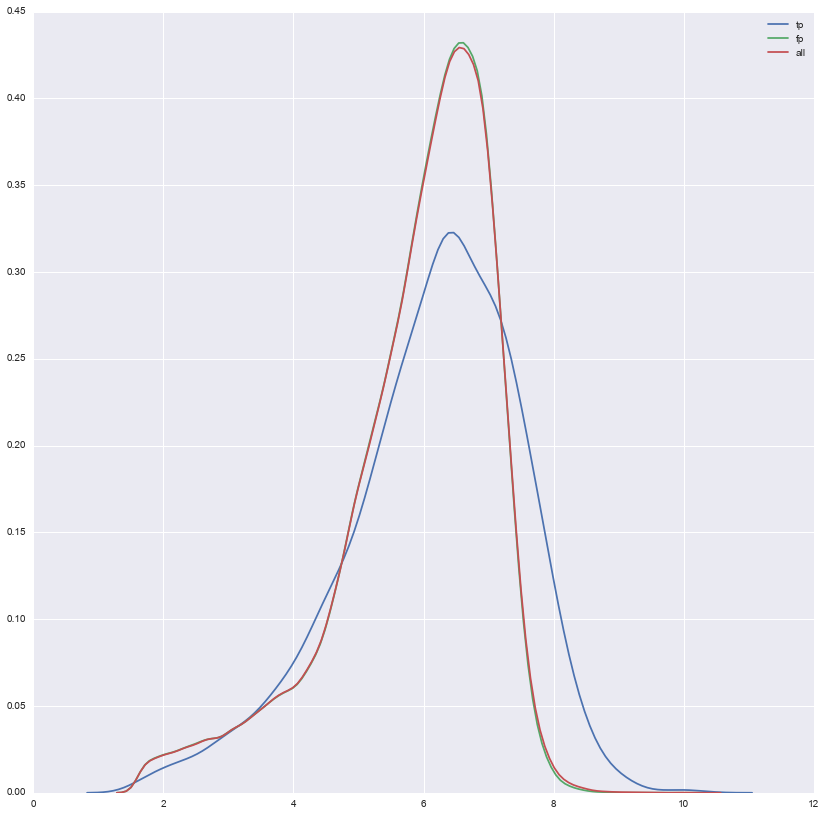

In [206]:
plt.figure(figsize=(14,14))
sns.set(color_codes=True)
sns.distplot(np.log(quals_tp),hist=False,label='tp')
sns.distplot(np.log(quals_fp),hist=False,label='fp')
sns.distplot(np.log(quals),hist=False,label='all')

### 2. Count homopolymers

In [133]:
df_left, df_right = count_homopolymers(reference,our_vcf)
df_left_tp, df_right_tp = count_homopolymers(reference,tp_vcf)
df_left_fp, df_right_fp = count_homopolymers(reference,fp_vcf)

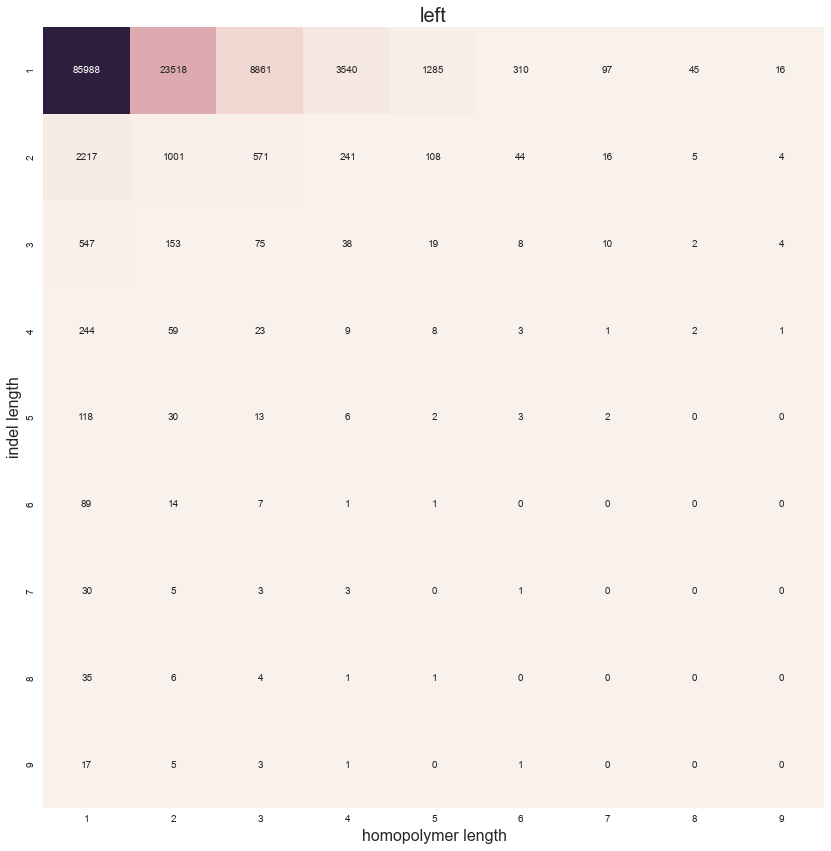

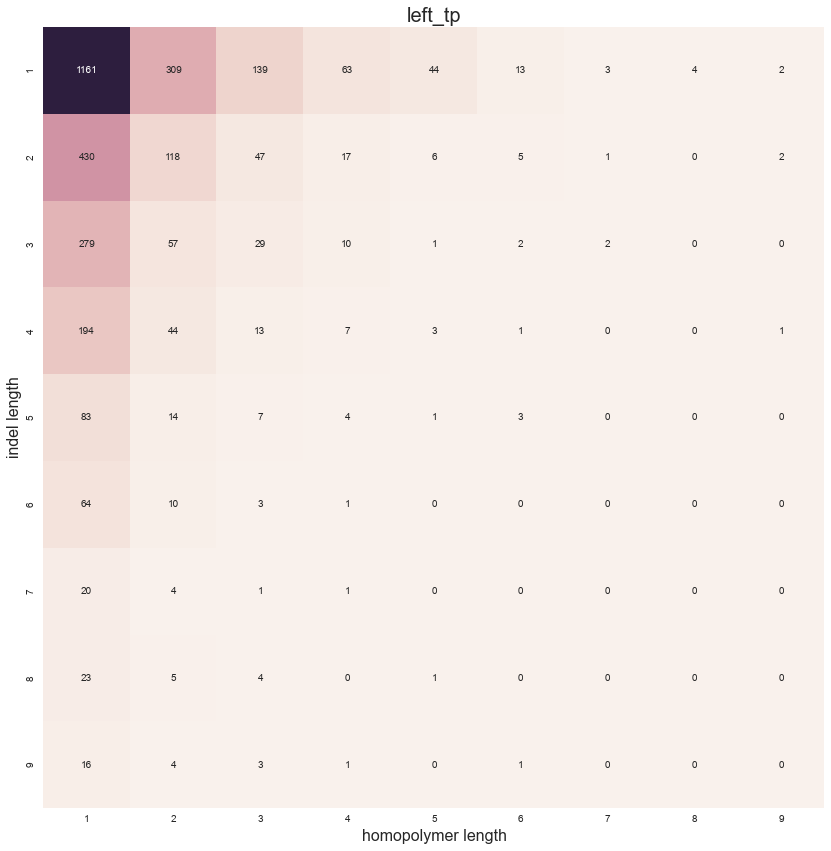

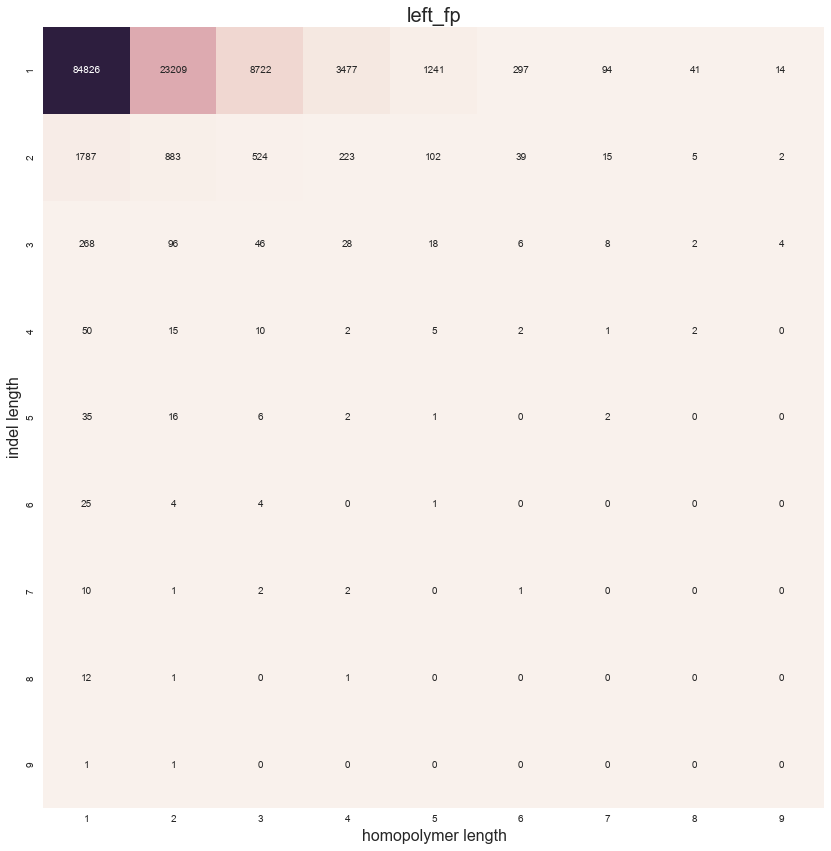

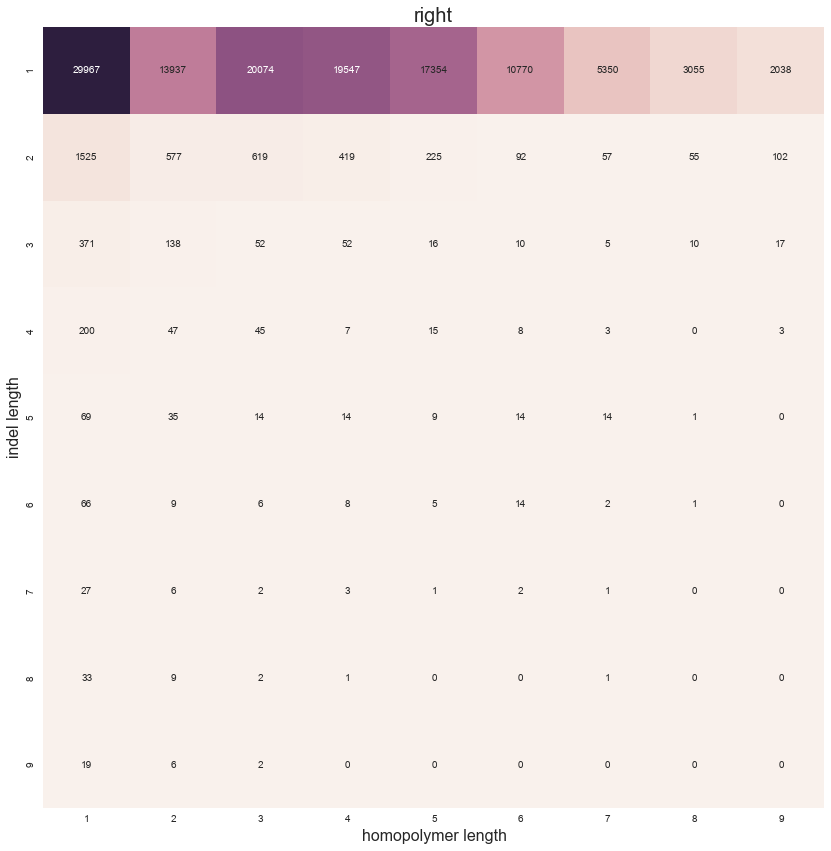

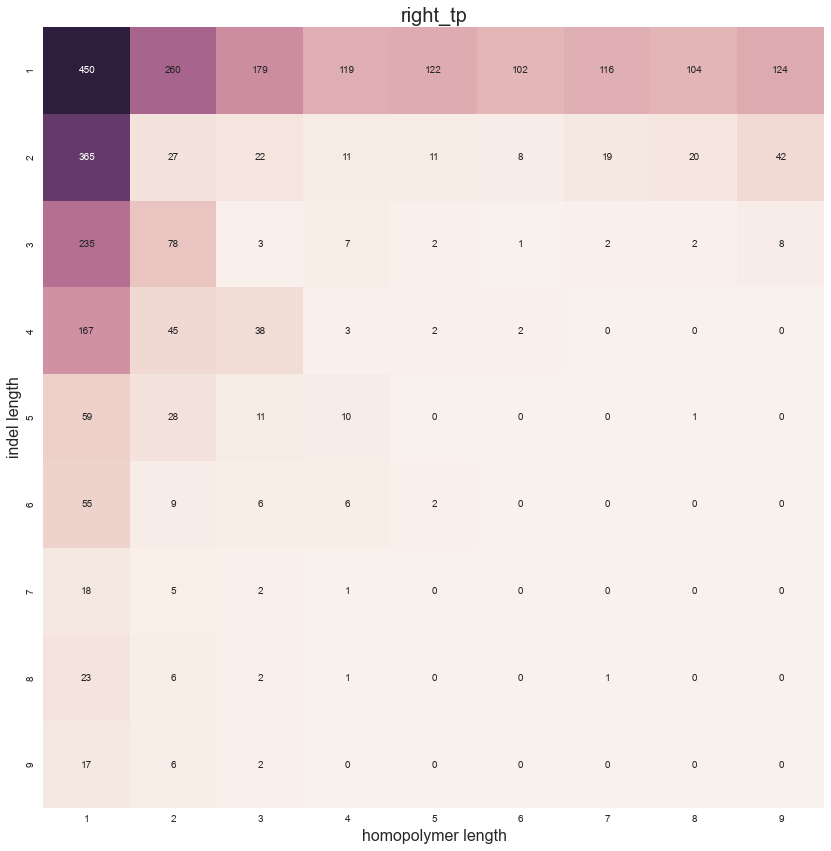

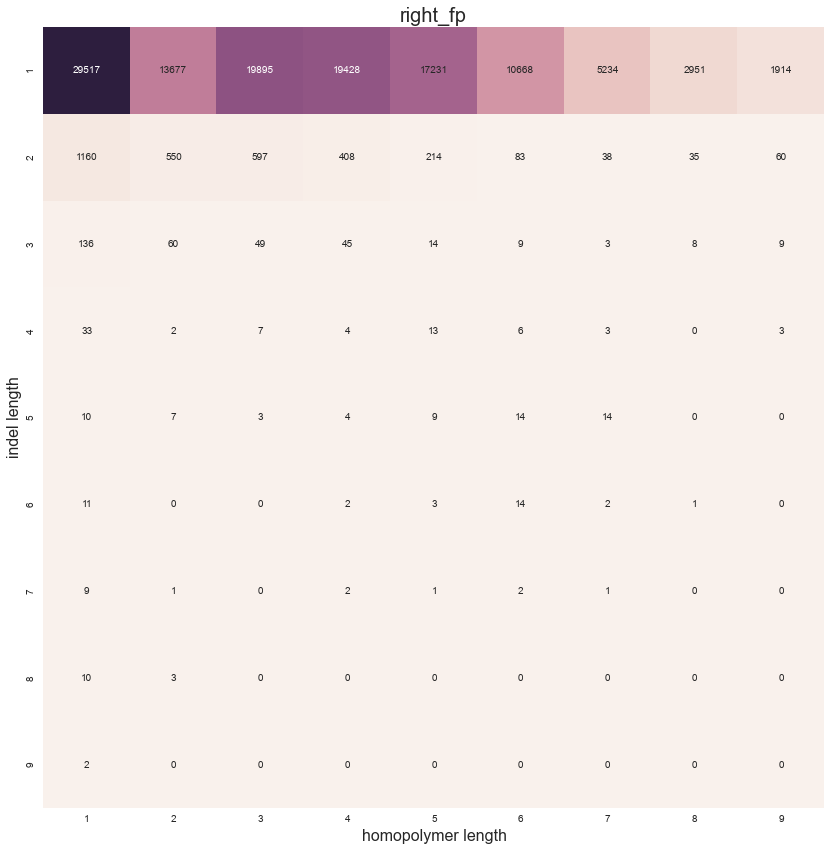

In [189]:
for df,name in [[df_left,'left'],[df_left_tp,'left_tp'],[df_left_fp,'left_fp'],[df_right,'right'],[df_right_tp,'right_tp'],[df_right_fp,'right_fp']]:
    fig = plt.figure(figsize=(14, 14), dpi=500)
    hmap = sns.heatmap(df.as_matrix()[1:10,1:10],cbar = False,annot = True, fmt = 'd',xticklabels = np.arange(9)+1,yticklabels = np.arange(9)+1)
    plt.xlabel('homopolymer length',fontsize=16)
    plt.ylabel('indel length',fontsize=16)
    plt.title(name,fontsize = 20)

Нормализованные распределения длин гомополимеров для инделов длины 1

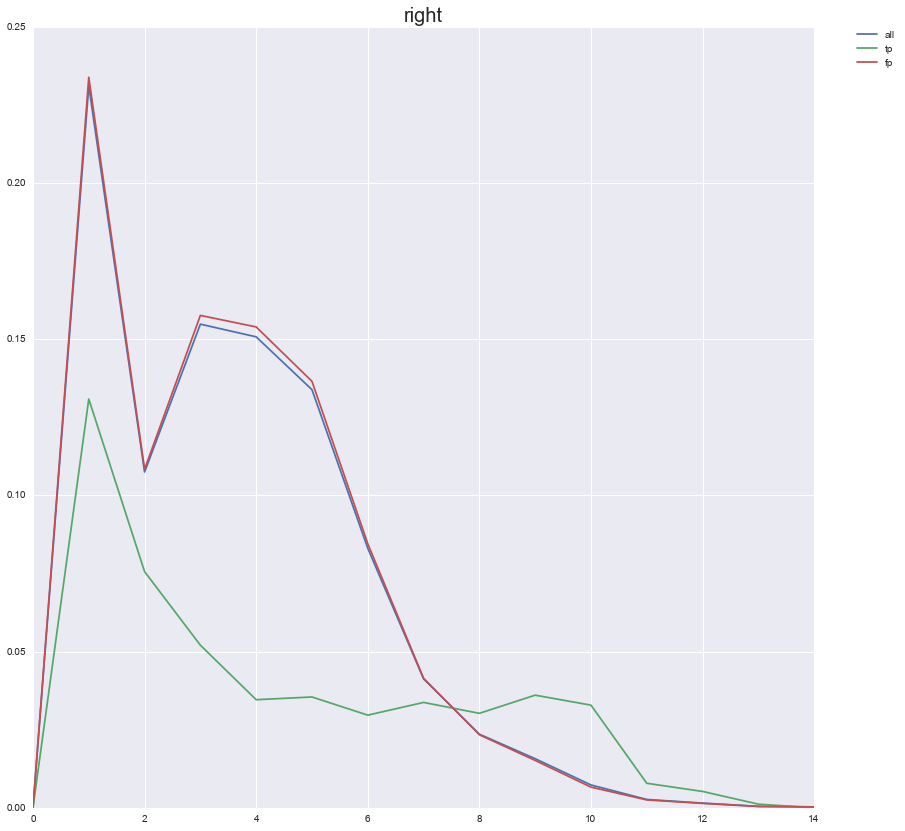

In [209]:
plt.figure(figsize=(14,14))
(df_right/df_right.sum().sum()).T[1][:15].plot(label=u"all")
(df_right_tp/df_right_tp.sum().sum()).T[1][:15].plot(label=u"tp")
(df_right_fp/df_right_fp.sum().sum()).T[1][:15].plot(label=u"fp")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('right',fontsize=20)
plt.show()

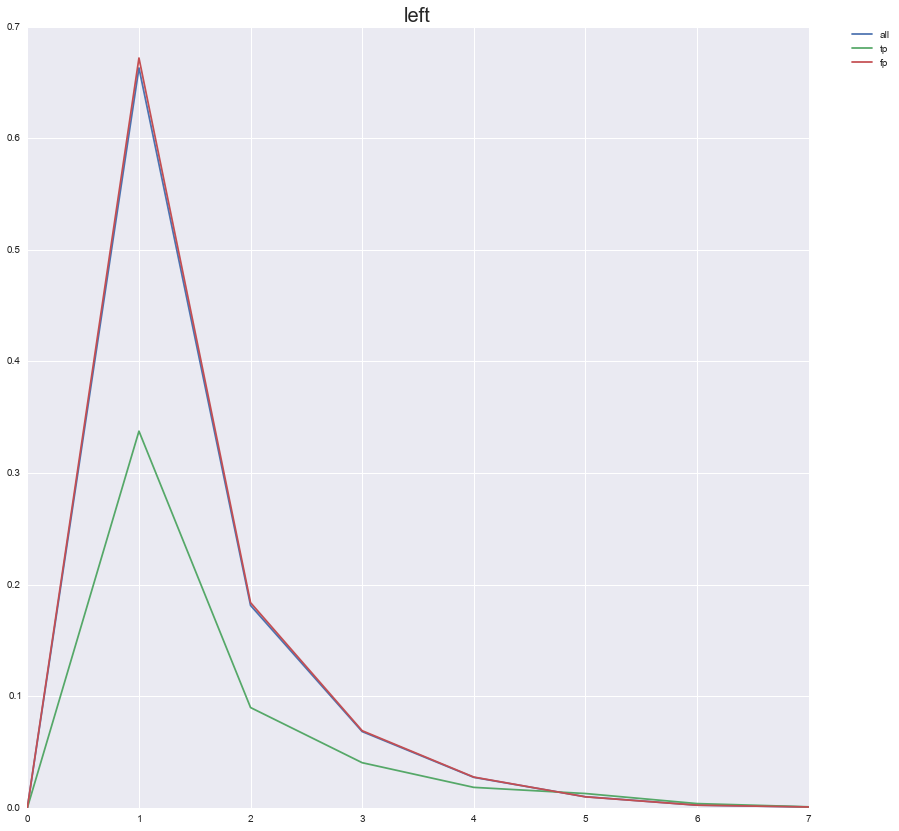

In [192]:
plt.figure(figsize=(14,14))
(df_left/df_left.sum().sum()).T[1][:8].plot(label=u"all")
(df_left_tp/df_left_tp.sum().sum()).T[1][:8].plot(label=u"tp")
(df_left_fp/df_left_fp.sum().sum()).T[1][:8].plot(label=u"fp")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('left',fontsize=20)
plt.show()

### 3. Count nucleotydes

In [134]:
freq_left, freq_right = count_freq(reference,our_vcf,15)
freq_left_tp, freq_right_tp = count_freq(reference,tp_vcf,15)
freq_left_fp, freq_right_fp = count_freq(reference,fp_vcf,15)

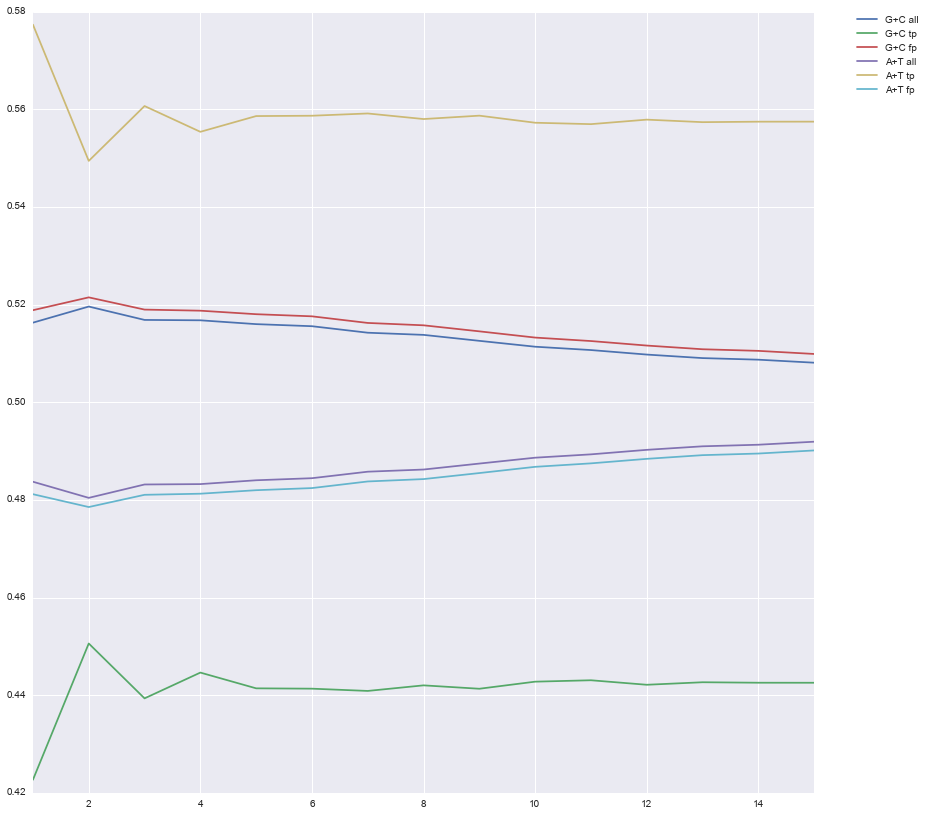

In [115]:
plt.figure(figsize=(14,14))
freq_left['G+C'].plot(label='G+C all')
freq_left_tp['G+C'].plot(label='G+C tp')
freq_left_fp['G+C'].plot(label='G+C fp')
freq_left['A+T'].plot(label='A+T all')
freq_left_tp['A+T'].plot(label='A+T tp')
freq_left_fp['A+T'].plot(label='A+T fp')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

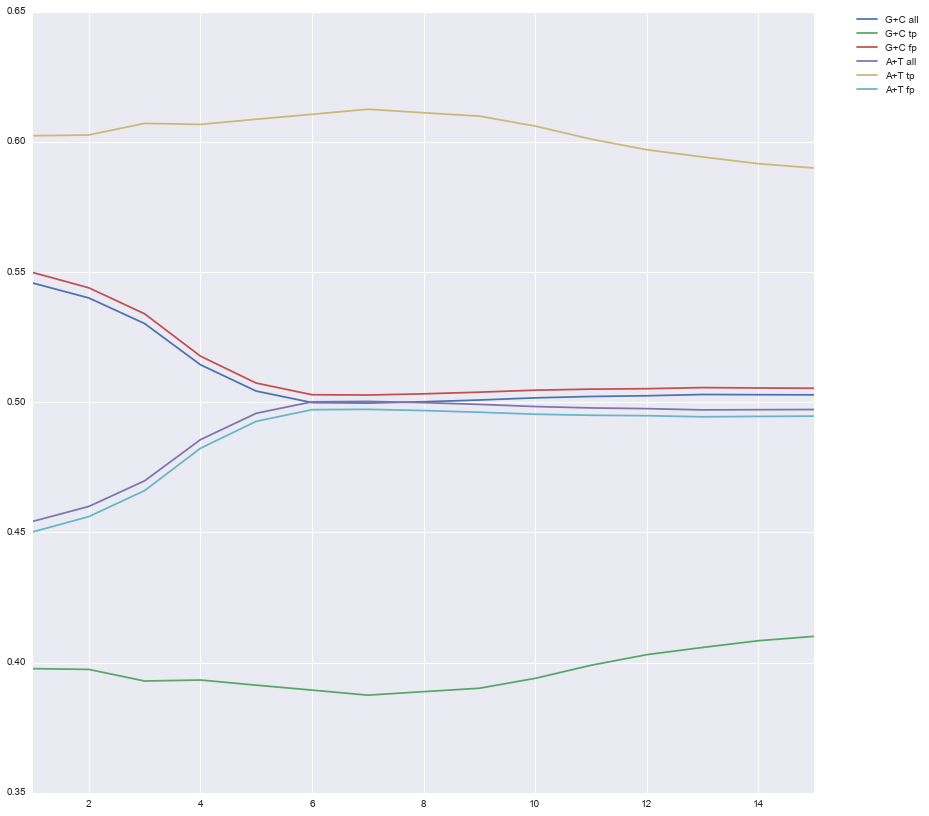

In [117]:
plt.figure(figsize=(14,14))
freq_right['G+C'].plot(label='G+C all')
freq_right_tp['G+C'].plot(label='G+C tp')
freq_right_fp['G+C'].plot(label='G+C fp')
freq_right['A+T'].plot(label='A+T all')
freq_right_tp['A+T'].plot(label='A+T tp')
freq_right_fp['A+T'].plot(label='A+T fp')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 4. PCA from tp and fp

In [20]:
data_X,data_y = feature_matrix(reference,tp_vcf,fp_vcf)

In [42]:
X_reduced = PCA(n_components=2).fit_transform(data_X.T.as_matrix())
X_red = pd.DataFrame()
X_red['1 eigen'] = X_reduced[:,0]
X_red['2 eigen'] = X_reduced[:,1]
X_red['truth'] = ['true positive' if int(x)==1 else 'false positive' for x in data_y]

         1 eigen   2 eigen           truth
0      -2.813055 -2.548040   true positive
1      -2.593975  0.059786   true positive
2      -1.768246 -2.008361   true positive
3      -2.698454 -1.323621   true positive
4      -2.468288  3.330448   true positive
5      -0.624369  0.579364   true positive
6      -2.606716  0.117533   true positive
7      -2.627482 -0.125876   true positive
8      -3.146835 -3.470483   true positive
9      -0.673587 -0.766409   true positive
10     -0.470047  3.430620   true positive
11     -2.809969  0.134611   true positive
12     -1.878981 -1.377364   true positive
13     -2.627654  1.233294   true positive
14     -2.601761 -0.026500   true positive
15     -2.655932 -1.778340   true positive
16     -0.465094  2.902087   true positive
17      2.274448 -0.749808   true positive
18     -0.541423  1.787421   true positive
19     -2.622112 -0.602394   true positive
20     -2.635619  1.404280   true positive
21     -2.562403  0.625310   true positive
22     -2.6

In [ ]:
%matplotlib inline
sns.lmplot(x='1 eigen',y='2 eigen',hue='truth',data=X_red)
plt.figure(figsize=(14, 14))


In [ ]:
samfile = pysam.AlignmentFile("/home/alexgri/Desktop/indels/GoldenStandard_OurAlgorithms/gcat_set_059-ready.bam", "rb")
#for read in samfile.fetch('1', 1019890, 1019891):
#     print read


for pileupcolumn in samfile.pileup('1', pos, pos+1):
    if (pileupcolumn.pos==pos or pileupcolumn.pos==pos+1 or pileupcolumn.pos==pos-1):
        print ("\ncoverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            #print pileupread.alignment.seq
            if not pileupread.is_del and not pileupread.is_refskip and (pos-pileupread.alignment.pos>=0) and (pos-pileupread.alignment.pos<len(pileupread.alignment.seq)):
                print ('\tbase in read %s = %s' %(pileupread.alignment.query_name,pileupread.alignment.query_sequence[pos - pileupread.alignment.pos]))
samfile.close()